# Post-impact temperature files & cooling setup
### Sarah Steele, 2023


## Utilities

In [1]:
## import important things
import os
import sys
import shutil

import numpy as np
import scipy.linalg
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline 
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import gmsh

sys.path.append(r"C:\Users\SteeleSarah\Researches\ImpactCooling\BasinMagCode\BasinCoolMag\BasinCoolMag")
from T_anomalies import *

In [2]:
# load important constants and parameters
# constants|
g = 3.70;               # gravitational acceleration at surface (m/s)

# material properties for pre-impact thermal profiles
# [regolith,crust, mantle]
bgmats_fluery24 = {    
    'phys_groups': ['regolith','crust','mantle'],       # physical groups                                 
    'depth':np.array([2.,35.,455.])*1000,               # depth (m)
    'k': np.array([0.3,2.,4.]),                         # thermal conductivity (W/m/K) (35 km crust w/ k=2.5, 2 km insulating megaregolith with k=0.3)
    'Cp': np.array([1000.,1000.,1142.]),                # specific heat capacity (J/K/kg)
    'kappa':np.array([1.04E-6,1.04E-6,1.04E-6]),        # thermal diffusivity (m^2 s^-1) 
    'rho':np.array([0.81*2900.,2900.,3380.])            # density (kg/m^3) (megaregolith density following formulation in Sori (2018) with 19% porosity, e.g. Xie, Zhang, & Huang (2022))
}

# material properties (assuming prescribed crustal lithology)
mats = {"Cp": bgmats_fluery24['Cp'][1],      # heat capacity (J k^-1 C^-1) 
        "K0": 19.3E9,  # adiabatic bulk modulus at zero pressure (GPa) (Gault & Heitowit, 1963)
        "n": 5.5,        # derivative of the bulk modulus (Gault & Heitowit, 1963)
        "rho": bgmats_fluery24['rho'][1],    # uncompressed density (kg/m^3) 
        "Dq":11700.,        # simple-to-complex crater transition diameter (Susorney+, 2016)
        "Tliq":1650.,    # liquidus temperature (K) (0 GPa liquidus for S-corrected lherzolite composition in Fig. 6B of Namur+ (2016))
        "Tsol": 1148.+273., # solidus temperature (K) (solidus following eqn in Fig. 6 caption of Namur+ (2016) @ 0 GPa)
        # "gradT":    ,# thermal gradient (C km^-1) (Babeyko & Zharkov (2000))
        "flux":   25.  ,  # heat flux (very approximately fits temperature at 35 km and 50 km in Figure 2 of Fleury+ (2024))
        "Tbase": 1050.,   # T at the base of the lithosphere (K) (Breuer+, 2007)
        "Tsurf": 440.    # T at the surface (K) (Padovan+ 2014)        
        }

# impact defaults
imdefs = {"vi"  :   42.5,     # impact velocity (km/s) (Le Feuvre & Wieczorek, 2008) 
          "theta":  np.pi/4 # impact angle (radians)
        }


# bgmats_thick = {
#     'depth':np.array([50.,])*1000,      # depth (m) (crust: Goossens+, 2022
#     'k': np.array([3.,3.,4.]),          # thermal conductivity (W/m/K) (Breuer+, 2007)
#     'Cp': np.array([,,1212.]),          # specific heat capacity (J/K/kg) (mantle: Michel+ 2013)
#     'kappa':np.array([,,7E-7]),         # thermal diffusivity (m^2 s^-1) (mantle: Michel+ 2013)
#     'rho':np.array([2500.,2500.,3500.])           # density (kg/m^3) (crust: Goossens+, 2022; mantle: Michel+, 2013)
# }

# bgmats_thin = {
#     'depth':np.array([26.,])*1000,      # depth (m) (crust: Sori, 2018)
#     'k': np.array([3.,3.,4.]),          # thermal conductivity (W/m/K) (Breuer+, 2007)
#     'Cp': np.array([,,1212.]),          # specific heat capacity (J/K/kg) (mantle: Michel+ 2013)
#     'kappa':np.array([,,7E-7]),         # thermal diffusivity (m^2 s^-1) (mantle: Michel+ 2013)
#     'rho':np.array([,3500.])           # density (kg/m^3) (crust: ; mantle: Michel+, 2013)
# }

# important stem locations
bms1 = 'BaseMeshes/'
cfgtemplate1 = 'config_template.cfg'
cfgtemplate3D = r'C:\Users\SteeleSarah\Researches\ImpactCooling\BasinMagCode\BasinCoolMag\BasinCoolMag\Preprocessing/config_template_3D.cfg'

In [3]:
def mod_bgmats_for_mesh(bgmats,max_depth):
    for i,di in enumerate(bgmats['depth']):
        if di > max_depth:
            phys_groups = bgmats['phys_groups'][:i+1]                          
            depths = np.copy(bgmats['depth'][:i+1])
            depths[-1] = max_depth
            depths = np.insert(depths,0,0.)
            return depths, phys_groups
        
    depths = np.insert(bgmats['depth'],0,0.)    
    return depths, bgmats['phys_groups']

## Pre-impact thermal profiles

In [4]:
## pre-impact thermal profile functions

# pre-impact thermal profile
def pitp(t):return

def pitp_fromfile(filepath,xv,zv):
    # load temperatures
    x0grid, z0grid, Teq = np.load(filepath)
    
    if x0grid[0] == xv and z0grid[:,0] == zv:
        return Teq
    else:
        # interpolate onto new x and z grids
        Teq_intrp = RectBivariateSpline(x0grid[0],z0grid[:,0],Teq)

        # evaluate over new coordinates
        return Teq_interp(xv,zv)
    
def pitp_auto(depth, Tsurf=mats["Tsurf"],bgmats=bgmats_fluery24,flux=mats['flux']):
    #T = np.zeros(depth.shape)
    
    zlist = np.arange(0,3000000.,0.5)
    Tlist = np.zeros(zlist.shape)
    
    grad = flux/bgmats['k']
    
    Tlist[zlist<=bgmats['depth'][0]] = Tsurf + zlist[zlist<=bgmats['depth'][0]]*grad[0]/1000
    
    Tthresh = bgmats['depth'][0]*grad[0]/1000+Tsurf
    for i in range(1,len(bgmats['depth'])):
        
        inds = np.logical_and(zlist<=bgmats['depth'][i], zlist>bgmats['depth'][i-1])
        d0 = bgmats['depth'][i-1]
        
        Tlist[inds] = Tthresh+ (zlist[inds]-d0)*grad[i]/1000
        
        Tthresh += (bgmats['depth'][i]-d0)*grad[i]/1000
        
    Tint = interp1d(zlist, Tlist)
    return Tint(depth)


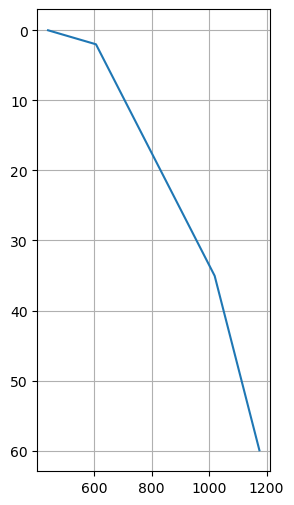

In [5]:
depths=np.arange(0.,60000.,50.)

plt.figure(figsize=(3,6))
plt.plot(pitp_auto(depths),depths/1000.)
plt.grid(True)
plt.gca().yaxis.set_inverted(True)

## Mesh-making

In [6]:
def make_mesh_rect2D(save_fp,depths,dxs,width,phys_groups,preview=False,mesh_type='tet'):
    """
    Creates a 2D stacked rectangular mesh using Gmsh based on the provided depths.

    Parameters:
    save_fp (str): File path to save the generated mesh.
    depths (list or numpy array): A list or array of depths for each layer of the mesh.
    dxs (list or numpy array): A list or array of characteristic element sizes for each layer.
    width (float): The width of the rectangular mesh.
    max_depth (float): The maximum depth of the mesh.
    phys_groups (list of str): Names of the physical groups for each layer. Should be one element shorter than depths.
    preview (bool): If True, display a preview of the mesh. Default is False.
    mesh_type (str): Type of mesh to generate ('tet' for triangular/tetrahedral, 'quad' for quadrahedral). Default is 'tet'.

    Returns:
    None: The function generates a .msh file containing the mesh and saves it to the specified file path.

    Example:
    depths = [0., -10., -20., -30.]
    dxs = [1., 1., 1., 1.]
    phys_groups = ["Regolith", "Crust", "Mantle"]
    make_mesh_rect2D("mesh.msh", depths, dxs, width=10, max_depth=-40)
    """
    gmsh.initialize()
    gmsh.model.add("stacked_rect_mesh")
    print(dxs)
    # add points for top and intermediate layers
    for i, depth in enumerate(depths):
        gmsh.model.geo.addPoint(0,-depth,0,dxs[i],2*i+1)
        gmsh.model.geo.addPoint(width,-depth,0,dxs[i],2*i+2)

    # # add points for the bottom
    # gmsh.model.geo.addPoint(0,-max_depth,0,dxs[i],2*i+3)
    # gmsh.model.geo.addPoint(width,-max_depth,0,dxs[i],2*i+4)

    # make points list
    points = np.arange(1,2*i+3)
    print(points)
    
    # make top line
    gmsh.model.geo.addLine(2,1,1)

    tot_lines = 1
    tot_loops = 1
    # create lines and surfaces
    for i in range(1,len(points)-2,2):
        p1, p2, p3, p4 = points[i-1:i+3]

        # make lines
        gmsh.model.geo.addLine(p2, p4, tot_lines+1)
        gmsh.model.geo.addLine(p4, p3, tot_lines+3)
        gmsh.model.geo.addLine(p3, p1, tot_lines+2)

        # make curve loop and plane surface
        print(p1,p2,p3,p4)
        gmsh.model.geo.addCurveLoop([tot_lines,tot_lines+1,tot_lines+3,tot_lines+2],tot_loops,reorient = True)
        gmsh.model.geo.addPlaneSurface([tot_loops],tot_loops)

        # increment counters
        tot_loops += 1
        tot_lines += 3

    # sychronize mesh
    gmsh.model.geo.synchronize()

    # to generate quadrangles instead of triangles, add
    # if mesh_type == 'quad':
        # gmsh.model.mesh.setRecombine(2, pl)    # add to generate

    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    
    # make physical groups
    for i,pg in enumerate(phys_groups):
        gmsh.model.addPhysicalGroup(2,[i+1], i+1, pg)
    
    lines = np.arange(1,tot_lines+1)
    # set boundary conditions
    gmsh.model.addPhysicalGroup(1,[lines[-1]], 1, "Bottom")
    gmsh.model.addPhysicalGroup(1,lines[2::3], 4, "Left (center)")
    gmsh.model.addPhysicalGroup(1,[1], 3, "Top")
    gmsh.model.addPhysicalGroup(1,lines[1::3], 2, "Right")
    
    # mesh the mesh!
    gmsh.model.mesh.generate(2)
    gmsh.write(save_fp)

    # launch the GUI to see the results:
    if preview:
        gmsh.fltk.run()

    gmsh.finalize()


def make_mesh_rect3D(save_fp, depths, dxs, x_bounds, y_bounds, phys_groups, preview=False, mesh_type='tet'):
    """
    Creates a 2D stacked rectangular mesh using Gmsh based on the provided depths.

    Parameters:
    save_fp (str): File path to save the generated mesh.
    depths (list or numpy array): A list or array of depths for each layer of the mesh.
    dxs (list or numpy array): A list or array of characteristic element sizes for each layer.
    width (float): The width of the rectangular mesh.
    max_depth (float): The maximum depth of the mesh.
    phys_groups (list of str): Names of the physical groups for each layer. Should be one element shorter than depths.
    preview (bool): If True, display a preview of the mesh. Default is False.
    mesh_type (str): Type of mesh to generate ('tet' for triangular/tetrahedral, 'quad' for quadrahedral). Default is 'tet'.

    Returns:
    None: The function generates a .msh file containing the mesh and saves it to the specified file path.

    Example:
    depths = [0., -10., -20., -30.]
    dxs = [1., 1., 1., 1.]
    phys_groups = ["Regolith", "Crust", "Mantle"]
    make_mesh_rect2D("mesh.msh", depths, dxs, width=10, max_depth=-40)
    """
    gmsh.initialize()
    gmsh.model.add("stacked_rect_mesh")
    
    # add points for top and intermediate layers
    for i, depth in enumerate(depths):
        gmsh.model.geo.addPoint(x_bounds[0],y_bounds[0],-depth,dxs[i],2*i+1)
        gmsh.model.geo.addPoint(x_bounds[1],y_bounds[0],-depth,dxs[i],2*i+2)

    # # add points for the bottom
    # gmsh.model.geo.addPoint(0,-max_depth,0,dxs[i],2*i+3)
    # gmsh.model.geo.addPoint(width,-max_depth,0,dxs[i],2*i+4)

    # make points list
    points = np.arange(1,2*i+3)
    
    # make top line
    gmsh.model.geo.addLine(2,1,1)

    tot_lines = 1
    tot_loops = 1
    # create lines and surfaces
    for i in range(1,len(points)-2,2):
        p1, p2, p3, p4 = points[i-1:i+3]

        # make lines
        gmsh.model.geo.addLine(p2, p4, tot_lines+1)
        gmsh.model.geo.addLine(p4, p3, tot_lines+3)
        gmsh.model.geo.addLine(p3, p1, tot_lines+2)

        # make curve loop and plane surface
        gmsh.model.geo.addCurveLoop([tot_lines,tot_lines+1,tot_lines+3,tot_lines+2],tot_loops,reorient = True)
        gmsh.model.geo.addPlaneSurface([tot_loops],tot_loops)

        # increment counters
        tot_loops += 1
        tot_lines += 3

    # sychronize mesh
    gmsh.model.geo.synchronize()
    
    # extrude the 2D surfaces into 3D
    for i in range(1, tot_loops):
        extruded = gmsh.model.geo.extrude([(2, i)], 0, y_bounds[1]-y_bounds[0], 0)
        print(extruded)
        gmsh.model.addPhysicalGroup(3, [i], i, phys_groups[i-1])
        # gmsh.model.geo.mesh.setSize(extruded, dxs[i-1])
        
    # sychronize mesh
    gmsh.model.geo.synchronize()
    
    # set mesh sizes
    for i, depth in enumerate(depths):
        depth_pts = gmsh.model.get_entities_in_bounding_box(x_bounds[0]-1.,y_bounds[0]-1.,-depth-1.,x_bounds[1]+1.,y_bounds[1]+1.,-depth+1.,dim=0)
        
        gmsh.model.geo.mesh.setSize(depth_pts, dxs[i])

    # set boundary conditions
    top_plane = gmsh.model.get_entities_in_bounding_box(x_bounds[0]-1.,y_bounds[0]-1.,-depths[0]-1.,x_bounds[1]+1.,y_bounds[1]+1.,-depths[0]+1.,dim=2)[0][1]
    bottom_plane = gmsh.model.get_entities_in_bounding_box(x_bounds[0]-1.,y_bounds[0]-1.,-depths[-1]-1.,x_bounds[1]+1.,y_bounds[1]+1.,-depths[-1]+1.,dim=2)[0][1]
    
    gmsh.model.addPhysicalGroup(2,[bottom_plane], 1, "Bottom")
    gmsh.model.addPhysicalGroup(2,[top_plane], 3, "Top")
    gmsh.model.geo.synchronize()
    # mesh the mesh!
    gmsh.model.mesh.generate(3)
    gmsh.write(save_fp)

    # launch the GUI to see the results:
    if preview:
        gmsh.fltk.run()

    gmsh.finalize()
  

def make_mesh_rect3D_lavatube(save_fp, depths, dxs, width, phys_groups, preview=False, mesh_type='tet'):
    """
    Creates a 2D stacked rectangular mesh using Gmsh based on the provided depths.

    Parameters:
    save_fp (str): File path to save the generated mesh.
    depths (list or numpy array): A list or array of depths for each layer of the mesh.
    dxs (list or numpy array): A list or array of characteristic element sizes for each layer.
    width (float): The width of the rectangular mesh.
    max_depth (float): The maximum depth of the mesh.
    phys_groups (list of str): Names of the physical groups for each layer. Should be one element shorter than depths.
    preview (bool): If True, display a preview of the mesh. Default is False.
    mesh_type (str): Type of mesh to generate ('tet' for triangular/tetrahedral, 'quad' for quadrahedral). Default is 'tet'.

    Returns:
    None: The function generates a .msh file containing the mesh and saves it to the specified file path.

    Example:
    depths = [0., -10., -20., -30.]
    dxs = [1., 1., 1., 1.]
    phys_groups = ["Regolith", "Crust", "Mantle"]
    make_mesh_rect2D("mesh.msh", depths, dxs, width=10, max_depth=-40)
    """
    gmsh.initialize()
    gmsh.model.add("stacked_rect_mesh")
    
    # add points for top and intermediate layers
    for i, depth in enumerate(depths):
        gmsh.model.geo.addPoint(0,0,-depth,dxs[i],2*i+1)
        gmsh.model.geo.addPoint(width,0,-depth,dxs[i],2*i+2)

    # # add points for the bottom
    # gmsh.model.geo.addPoint(0,-max_depth,0,dxs[i],2*i+3)
    # gmsh.model.geo.addPoint(width,-max_depth,0,dxs[i],2*i+4)

    # make points list
    points = np.arange(1,2*i+3)
    
    # make top line
    gmsh.model.geo.addLine(2,1,1)

    tot_lines = 1
    tot_loops = 1
    # create lines and surfaces
    for i in range(1,len(points)-2,2):
        p1, p2, p3, p4 = points[i-1:i+3]

        # make lines
        gmsh.model.geo.addLine(p2, p4, tot_lines+1)
        gmsh.model.geo.addLine(p4, p3, tot_lines+3)
        gmsh.model.geo.addLine(p3, p1, tot_lines+2)

        # make curve loop and plane surface
        gmsh.model.geo.addCurveLoop([tot_lines,tot_lines+1,tot_lines+3,tot_lines+2],tot_loops,reorient = True)
        gmsh.model.geo.addPlaneSurface([tot_loops],tot_loops)

        # increment counters
        tot_loops += 1
        tot_lines += 3

    # sychronize mesh
    gmsh.model.geo.synchronize()
    
    # extrude the 2D surfaces into 3D
    for i in range(1, tot_loops):
        extruded = gmsh.model.geo.extrude([(2, i)], 0, width, 0)
        print(extruded)
        # gmsh.model.geo.mesh.setSize(extruded, dxs[i-1])
        
    # sychronize mesh
    gmsh.model.geo.synchronize()
    
    # set mesh sizes
    for i, depth in enumerate(depths):
        depth_pts = gmsh.model.get_entities_in_bounding_box(-width-1.,-width-1.,-depth-1.,width+1.,width+1.,-depth+1.,dim=0)
        
        gmsh.model.geo.mesh.setSize(depth_pts, dxs[i])
        
    # add lava tube
    
    
    
    

    # set boundary conditions
    top_plane = gmsh.model.get_entities_in_bounding_box(-width-1.,-width-1.,-depths[0]-1.,width+1.,width+1.,-depths[0]+1.,dim=2)[0][1]
    bottom_plane = gmsh.model.get_entities_in_bounding_box(-width-1.,-width-1.,-depths[-1]-1.,width+1.,width+1.,-depths[-1]+1.,dim=2)[0][1]
    
    gmsh.model.addPhysicalGroup(2,[bottom_plane], 1, "Bottom")
    gmsh.model.addPhysicalGroup(2,[top_plane], 3, "Top")
    
    # mesh the mesh!
    gmsh.model.mesh.generate(3)
    gmsh.write(save_fp)

    # launch the GUI to see the results:
    if preview:
        gmsh.fltk.run()

    gmsh.finalize()
  

## Basin class

In [7]:
## basin class
class Basin:
    def __init__(self,bname,Df,bgmats=bgmats_fluery24):
        self.name = bname           # basin name
        self.Df = Df  # final diameter
        self.bgmats = bgmats
        
        # get the rest of the important parameters
        self.getparams()
        
        return
        
    def doallT(self,xvals,zvals,pitp,savefp,mesh_max_depth,mesh_width,mesh_dxs,mesh_preview=False,mesh_type='tet',bmstem=bms1,cfgtemp=cfgtemplate1,**shockkw):
        
        # make save dir if necessary
        if not os.path.isdir(savefp):
            os.mkdir(savefp)
        
        # set surface temperature
        self.Tsurf = pitp(0)
            
        # make temperature field
        print('Making post-impact T field')
        Tout = self.makeTfield(pitp,xvals,zvals,**shockkw)
        Tmat = Tout['Tconvadj']
        
        # save x, z, and T files
        xfp,zfp,Tfp = self.makexzT(savefp,xvals*1000,-zvals*1000,Tmat)
        
        # # choose appropriate mesh file
        # meshlims = np.array([[5,10,50,100,250,500],[10,50,100,250,500,800]])
        # meshinds = meshlims[:,(meshlims[0,:]<=self.Dtc)*(meshlims[1,:]>self.Dtc)]

        # basemeshfp = bmstem + str(meshinds[0,0]) + '_' + str(meshinds[1,0]) + 'km_rcm.inp'

        # print('Using mesh file ' + str(meshinds[0,0]) + '_' + str(meshinds[1,0]) + 'km_rcm.inp')
        
        # # modify and save new mesh 
        # newmeshfp = savefp + str(meshinds[0,0]) + '_' + str(meshinds[1,0]) + 'km_rcm.inp'
        # newmeshdf,xright,zbottom = self.makemesh(basemeshfp,savefp)
        #(save_fp,depths,dxs,width,max_depth,phys_groups,preview=False,mesh_type='tet')
        
        depths, phys_groups = mod_bgmats_for_mesh(self.bgmats,mesh_max_depth)
        
        make_mesh_rect3D(os.path.join(savefp,'mesh3.msh'),depths,
                         mesh_dxs,mesh_width,phys_groups,
                         preview=mesh_preview,mesh_type=mesh_type)

        # make config file
        self.makeconfig(cfgtemp,savefp,xfp,zfp,Tfp,os.path.join(savefp,'mesh.msh'),mesh_width,mesh_max_depth)
        
        # make output file
        outputfp = savefp + 'output';
        if not os.path.isdir(outputfp):
            os.mkdir(outputfp)
        
        return 
    
    
    
    def getparams(self):
        '''
        Calculate other important crater parameters.
        
        Dtr: transient crater diameter
        cudis: central uplift displacement
        Rim: estimated impactor radius
        '''
        
        self.Dtc = ((1/0.91)*mats["Dq"]**(0.09)*(self.Df*1000))**(1/1.125)/1.2/1000   # Abramov & Kring (2005)
        self.cudis = 0.06*(self.Df)**(1.1)                         # Grieve et al. (1981)
        self.uplift = 1
        
        return
        
    def makeTfield(self,pitp,xvals,zvals,**kwargs):
        '''
        Make np array of initial temperature profile.
        
        pitp: pre-impact temperature profile (C)
        rdist: radial extent of domain (km)
        zdist: depth extent of domain (km)
        res: resolution of domain (km)
        '''
        # set surface temperature
        self.Tsurf = pitp(0)
        
        # initialize base position arrays
        dist,depth = np.meshgrid(xvals,zvals)
        
        # get shock temperature profile
        # Tmat = shockT(depth,dist,self.Dtc,pitp,self.Tsurf,**kwargs)
        Tmat = make_impact_T(dist,depth,self.Dtc,pitp,self.Tsurf,g,imdefs["vi"],imdefs["theta"],mats["n"],mats["K0"],mats["Cp"],mats["rho"],mats["Dq"],**kwargs)
        
        self.Tibounds = [np.max(dist),np.max(depth)]

        
        print('Made temperature field')
        return Tmat
   

    def makexzT(self,filepath,xvals,zvals,Tmat,app=''):
        '''
        Make x, z, and T files. You should have already run makeTfield over a domain
        as large or larger than the x-z space used here.
        '''
        xfp = filepath + r'xc' + app + '.txt'
        zfp = filepath + r'zc' + app + '.txt'
        Tfp = filepath + 'T_smooth' + app + '.txt'
        Teqfp = filepath + 'T_eq_smooth' + app + '.txt'

        # write x and z files
        np.savetxt(xfp,xvals.reshape(-1,1),fmt='%6.5f')
        np.savetxt(zfp,zvals.reshape(-1,1)[::-1],fmt='%6.5f')
        print('Wrote x to ' + xfp)
        print('Wrote z to ' + zfp)
        
        # write T file
        np.savetxt(Tfp,Tmat[::-1],fmt='%.2f')
        print('Wrote T to ' + Tfp)
        
        # write equilibrium T file
        T_eqp = np.tile(Tmat[:,-1],(len(xvals),1)).T
        np.savetxt(Teqfp,T_eqp[::-1])
        
        return xfp, zfp, Tfp
    
    
    def makemesh(self,basemeshfp,savefp):
        '''
        Load mesh from file and:
        1. Add a melt sheet or ejecta blanket above the crater if desired
        2. Save mesh grid locations to mesh_params.txt file
        '''
        # load in mesh
        dfbase = pd.read_csv(basemeshfp, sep=" ",names=[1,2,3,4,5,6,7,8,9,10,11], skiprows=1, engine='python');
        
        sec1 = dfbase[dfbase[3]!='quad'].astype('float')
        
        shutil.copy2(basemeshfp,savefp + 'mesh.inp')
        shutil.copy2(basemeshfp[:-4]+'.svg',savefp + 'mesh.svg')
        print(basemeshfp[:-4]+'.svg')
            
        # find unique indices 
        xun = np.sort(sec1[3].unique())
        zun = np.sort(sec1[4].unique())[::-1]
        
        xunm, zunm = np.meshgrid(xun,zun)
        meshparams = np.concatenate((xunm.flatten().reshape(-1,1),zunm.flatten().reshape(-1,1)),axis=1)
        np.savetxt(savefp+'mesh_params.txt', meshparams)
            
        # get locations of right and bottom boundaries
        xright = sec1[3].max()
        zbottom = dfbase[4].min()
        
        return dfbase, xright, zbottom
    
    
    def makeconfig(self,templatefp,savefp,xfp,zfp,Tfp,meshfp,xright,zbottom):
        # make copy of config template
        cfgsave = savefp + 'config.cfg'
        shutil.copy(templatefp,cfgsave) 
        
        cfg = open(cfgsave, "r")

        list_of_lines = cfg.readlines()
        
        # set file paths
        list_of_lines[3] = 'mesh_filename = "' + meshfp +'";\n';
        list_of_lines[4] = 'output_folder = "' + savefp + 'output\"' + ';\n';
        list_of_lines[5] = 'x_file        = "' + xfp + '";\n';
        list_of_lines[6] = 'z_file        = "' + zfp + '";\n';
        list_of_lines[7] = 'temp_file     = "' + Tfp + '";\n';
        list_of_lines[8] = 'eq_temp_file     = "' + savefp + 'T_eq_smooth.txt' + '";\n';
        
        list_of_lines[14] = f'    k               = [' + ', '.join(['%.1f']*len(self.bgmats["k"]))% tuple(self.bgmats["k"])+'];        // double, thermal conductivity W/m/K\n'; 
        list_of_lines[15] = f'    cp              = [' + ', '.join(['%.1f']*len(self.bgmats["Cp"]))% tuple(self.bgmats["Cp"])+'];  // double, specific heat capacity J/K/kg\n'; 
        list_of_lines[16] = f'    rho             = [' + ', '.join(['%.1f']*len(self.bgmats["rho"]))% tuple(self.bgmats["rho"])+'];   // double, density, kg/m^3\n'; 
        # set surface temperature
        list_of_lines[17] = f'    T_surf          = {self.Tsurf:1.1f};             // double, surface temperature\n'

        # set material ids (gmsh cannot have 0 for material ids, but mars_heat treats them as indices)
        list_of_lines[29] = '    material_id                 = [' + ', '.join(['%d']*len(self.bgmats["rho"]))% tuple(range(1,len(self.bgmats["rho"])+1))+']; // regolith, crust, lithosphere, mantle\n' 
        
        # set mesh boundaries
        list_of_lines[73] = '    x_right  = %.1f;  // double\n'%xright;
        list_of_lines[74] = '    z_bottom = %.1f; // double\n'%zbottom;
        
        # save new config file
        cfg = open(cfgsave, "w")

        cfg.writelines(list_of_lines)
        cfg.close()
        
        return
        

## Lava Tube class

In [27]:
## basin class
class LavaTube:
    def __init__(self,lava_T,start_point,end_point,tube_rad,bgmats=bgmats_fluery24):
        self.bgmats = bgmats
        self.lava_T = lava_T
        self.start_point = start_point
        self.end_point = end_point
        self.tube_rad = tube_rad
        
        return
        
    def doallT(self,xvals,yvals,zvals,pitp,savefp,mesh_dxs,mesh_preview=False,mesh_type='tet',bmstem=bms1,cfgtemp=cfgtemplate3D,**shockkw):
        
        # make save dir if necessary
        if not os.path.isdir(savefp):
            os.mkdir(savefp)
        
        # set surface temperature
        self.Tsurf = pitp(0)
        
        # get x and y bounds
        x_bounds = [np.min(xvals),np.max(xvals)]
        y_bounds = [np.min(yvals),np.max(yvals)]
            
        # make temperature field
        print('Making post-impact T field')
        Tmat = self.makeTfield(pitp,xvals,yvals,zvals,**shockkw)
        
        # save x, z, and T files
        xfp,yfp,zfp,Tfp = self.makexyzT(savefp,xvals,yvals,-zvals,Tmat)
        
        depths, phys_groups = mod_bgmats_for_mesh(self.bgmats,np.max(np.abs(zvals)))
        
        make_mesh_rect3D(os.path.join(savefp,'mesh3.msh'),depths,
                         mesh_dxs,x_bounds,y_bounds,phys_groups,
                         preview=mesh_preview,mesh_type=mesh_type)

        # make config file
        self.makeconfig(cfgtemp,savefp,xfp,yfp,zfp,Tfp,os.path.join(savefp,'mesh.msh'),x_bounds,y_bounds,np.min(-zvals))
        
        # make output file
        outputfp = savefp + 'output';
        if not os.path.isdir(outputfp):
            os.mkdir(outputfp)
        
        self.Tmat = Tmat
        
        return
        
    def makeTfield(self,pitp,xvals,yvals,zvals,**kwargs):
        '''
        Make np array of initial temperature profile.
        
        pitp: pre-impact temperature profile (C)
        rdist: radial extent of domain (km)
        zdist: depth extent of domain (km)
        res: resolution of domain (km)
        '''
        # set surface temperature
        self.Tsurf = pitp(0)
        
        self.Tibounds = [np.max(xvals),np.max(yvals),-np.max(zvals)]
        
        # initialize base position arrays
        xg,yg,zg = np.meshgrid(xvals,yvals,zvals)
        
        # get shock temperature profile
        # Tmat = shockT(depth,dist,self.Dtc,pitp,self.Tsurf,**kwargs)
        Tmat = make_lava_tube_T(xg,yg,-zg,self.start_point,self.end_point, self.tube_rad, self.lava_T, baseline_value=pitp(zg))
        
        print('Made temperature field')
        return Tmat
   

    def makexyzT(self,filepath,xvals,yvals,zvals,Tmat,app=''):
        '''
        Make x, y, z, and T files. You should have already run makeTfield over a domain
        as large or larger than the x-z space used here.
        '''
        xfp = filepath + 'xc' + app + '.txt'
        yfp = filepath + 'yc' + app + '.txt'
        zfp = filepath + 'zc' + app + '.txt'
        Tfp = filepath + 'T_smooth' + app + '.txt'
        Teqfp = filepath + 'T_eq_smooth' + app + '.txt'

        # write x and z files
        np.savetxt(xfp,xvals.reshape(-1,1),fmt='%6.5f')
        np.savetxt(yfp,yvals.reshape(-1,1),fmt='%6.5f')
        np.savetxt(zfp,zvals.reshape(-1,1)[::-1],fmt='%6.5f')
        print('Wrote x to ' + xfp)
        print('Wrote y to ' + yfp)
        print('Wrote z to ' + zfp)
        
        # write T file
        np.savetxt(Tfp,Tmat[:,:,::-1].reshape(-1,len(zvals)),fmt='%.2f')
        print('Wrote T to ' + Tfp)
        
        # write equilibrium T file
        T_eqp = np.tile(Tmat[:,-1,:],(len(xvals),1,1))
        np.savetxt(Teqfp,T_eqp[:,:,::-1].reshape(-1,len(zvals)))
        
        return xfp, yfp, zfp, Tfp
    
    
    def makeconfig(self,templatefp,savefp,xfp,yfp,zfp,Tfp,meshfp,x_bounds,y_bounds,zbottom):
        # make copy of config template
        cfgsave = savefp + 'config.cfg'
        shutil.copy(templatefp,cfgsave) 
        
        cfg = open(cfgsave, "r")

        list_of_lines = cfg.readlines()
        
        # set file paths
        list_of_lines[3] = 'mesh_filename = "' + meshfp +'";\n';
        list_of_lines[4] = 'output_folder = "' + savefp + 'output\"' + ';\n';
        list_of_lines[5] = 'x_file        = "' + xfp + '";\n';
        list_of_lines[6] = 'y_file        = "' + yfp + '";\n';
        list_of_lines[7] = 'z_file        = "' + zfp + '";\n';
        list_of_lines[8] = 'temp_file     = "' + Tfp + '";\n';
        list_of_lines[9] = 'eq_temp_file     = "' + savefp + 'T_eq_smooth.txt' + '";\n';
        
        list_of_lines[15] = f'    k               = [' + ', '.join(['%.1f']*len(self.bgmats["k"]))% tuple(self.bgmats["k"])+'];        // double, thermal conductivity W/m/K\n'; 
        list_of_lines[16] = f'    cp              = [' + ', '.join(['%.1f']*len(self.bgmats["Cp"]))% tuple(self.bgmats["Cp"])+'];  // double, specific heat capacity J/K/kg\n'; 
        list_of_lines[17] = f'    rho             = [' + ', '.join(['%.1f']*len(self.bgmats["rho"]))% tuple(self.bgmats["rho"])+'];   // double, density, kg/m^3\n'; 
        # set surface temperature
        list_of_lines[18] = f'    T_surf          = {self.Tsurf:1.1f};             // double, surface temperature\n'

        # set material ids (gmsh cannot have 0 for material ids, but mars_heat treats them as indices)
        list_of_lines[20] = '    material_id                 = [' + ', '.join(['%d']*len(self.bgmats["rho"]))% tuple(range(1,len(self.bgmats["rho"])+1))+']; // regolith, crust, lithosphere, mantle\n' 
        
        # set mesh boundaries
        list_of_lines[73] = '    x_min  = %.1f;  // double\n'%x_bounds[0];
        list_of_lines[74] = '    x_max  = %.1f;  // double\n'%x_bounds[1];
        list_of_lines[75] = '    y_min  = %.1f;  // double\n'%y_bounds[0];
        list_of_lines[76] = '    y_max  = %.1f;  // double\n'%y_bounds[1];
        list_of_lines[77] = '    z_bottom = %.1f; // double\n'%zbottom;
        
        # save new config file
        cfg = open(cfgsave, "w")

        cfg.writelines(list_of_lines)
        cfg.close()
        
        return
        

## Workspace

In [ ]:
xv100 = np.arange(-10,10.1,0.25)*1000.
yv100 = np.arange(-12,12.1,0.25)*1000.
zv100 = np.arange(0,15.1,0.25)*1000.

save_fp = r'C:\Users\SteeleSarah\Researches\Reviews/LT2000/'
LT2000 = LavaTube(mats['Tsol']+300,[-5000.,-5000.,-5000],[5000.,5000.,-5000.],2000.,bgmats=bgmats_fluery24)
LT2000.doallT(xv100,yv100,zv100,pitp_auto,save_fp,[500.,500.,1000.,1000.],mesh_preview=False)

Making post-impact T field
Made temperature field
Wrote x to C:\Users\SteeleSarah\Researches\Reviews/LT2000/xc.txt
Wrote y to C:\Users\SteeleSarah\Researches\Reviews/LT2000/yc.txt
Wrote z to C:\Users\SteeleSarah\Researches\Reviews/LT2000/zc.txt
Wrote T to C:\Users\SteeleSarah\Researches\Reviews/LT2000/T_smooth.txt
[(2, 29), (3, 1), (2, 16), (2, 20), (2, 24), (2, 28)]
[(2, 51), (3, 2), (2, 24), (2, 42), (2, 46), (2, 50)]


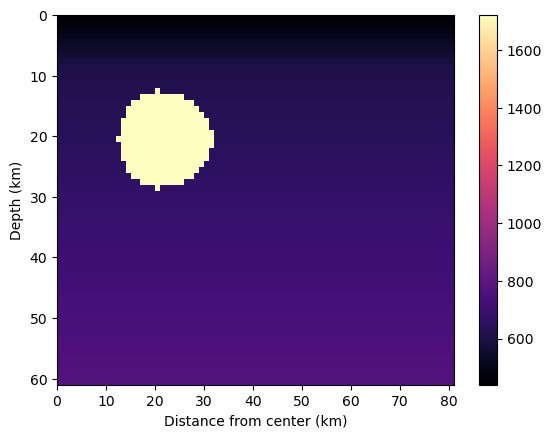

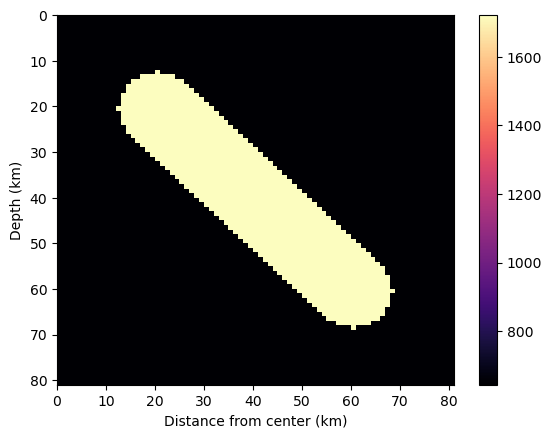

In [26]:
plt.figure()
plt.pcolormesh(LT2000.Tmat[:,20,:].T,cmap=plt.cm.magma)
plt.colorbar()
# plt.title(f'{time_n(test_step)/1e6:1.2f} Myr')
plt.xlabel('Distance from center (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()

plt.figure()
plt.pcolormesh(LT2000.Tmat[:,:,20].T,cmap=plt.cm.magma)
plt.colorbar()
# plt.title(f'{time_n(test_step)/1e6:1.2f} Myr')
plt.xlabel('Distance from center (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()

In [10]:
xv100 = np.arange(-10,10.1,0.5)*1000.
yv100 = np.arange(-10,10.1,0.5)*1000.
zv100 = np.arange(0,15.1,0.5)*1000.

save_fp = r'C:\Users\SteeleSarah\Researches\Reviews/LT2000/'
LT2000 = LavaTube(mats['Tliq']-100,[-5000.,-5000.,-5000],[5000.,5000.,-5000.],2000.,bgmats=bgmats_fluery24)
LT2000.doallT(xv100,yv100,zv100,pitp_auto,save_fp,[500.,500.,2000.,2000.],mesh_preview=False)

Making post-impact T field
Made temperature field
Wrote x to C:\Users\SteeleSarah\Researches\Reviews/LT2000/xc.txt
Wrote y to C:\Users\SteeleSarah\Researches\Reviews/LT2000/yc.txt
Wrote z to C:\Users\SteeleSarah\Researches\Reviews/LT2000/zc.txt
Wrote T to C:\Users\SteeleSarah\Researches\Reviews/LT2000/T_smooth.txt
[(2, 29), (3, 1), (2, 16), (2, 20), (2, 24), (2, 28)]
[(2, 51), (3, 2), (2, 24), (2, 42), (2, 46), (2, 50)]


In [11]:
# xv100 = np.arange(0,100.1,0.25)
# zv100 = np.arange(0,100.1,0.25)

# n = 77
# save_fp = r'C:\Users\SteeleSarah\Researches\Reviews/77km/'
# d100km = Basin('%d km diameter'%n,n)
# dfbase=d100km.doallT(xv100,zv100,pitp_auto,save_fp,40000.,40000.,[1000.,1000.,5000.,2000.],mesh_preview=True)

